In [ ]:
# ---------------------- Notes ----------------------
# Password (assumed to be stored securely): 
# Due to time constrains the code may not be fully optimised
# If no connection to MongoDB can be established, try running "net start MongoDB" in cmd 
# If no connection to Microsoft SQL can be established, ensure you're connected to the UoE 'eduroam' wifi service (be on campus or use a VPN)

In [ ]:
# ---------------------- Compatibility Requirements ----------------------
# Python: 3.12.3
# pyodbc: 5.0.1
# pandas: 2.2.2
# numpy: 1.26.4
# matplotlib: 3.8.0
# seaborn: 0.13.2
# sklearn: 1.2.2
# pymongo: 4.11.3
# nltk-3.9.1
# textblob-0.19.0

# Requires MongoDB Community Server 8.0.6 to be installed on the machine

In [1]:
# Import libraries
# Common
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MicrosoftSQL 
import pyodbc
import warnings
import getpass
#import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV

# MongoDB
from pymongo import MongoClient
from textblob import TextBlob
import json

# Suppress pandas warnings about DBAPI connections
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# ---------------------- Establish Connection with SQL and NoSQL ----------------------
def get_sql_connection():
    """
    Establishes and returns a connection to the SQL Server.
    """
    server = "mcruebs04.isad.isadroot.ex.ac.uk"
    database = "BEMM459_GroupZ"
    username = "GroupZ"
    password = getpass.getpass("Enter database password: ")
    conn = pyodbc.connect(
        f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}")
    print("✅ SQL Server connection established.")
    return conn

def get_mongodb_connection():
    """
    Connects to MongoDB and returns the BudgetCompensation database.
    """
    client = MongoClient("mongodb://localhost:27017/")
    db = client["BudgetCompensation"]
    print("✅ MongoDB connection established.")
    return db

# Establish SQL Server connection
sql_conn = get_sql_connection()
sql_cursor = sql_conn.cursor()

# Establish MongoDB connection and retrieve the database
mongo_db = get_mongodb_connection()

# Get collections for employee and manager feedback
employee_collection = mongo_db["EmployeeFeedback"]
manager_collection = mongo_db["ManagerFeedback"]


print("✅ All connections are set up and ready to use.")

Enter database password: ········
✅ SQL Server connection established.
✅ MongoDB connection established.
✅ All connections are set up and ready to use.


In [3]:
# ---------------------- Define Functions ----------------------
# ---------------------- 1. Helper Functions for Input ----------------------
def prompt_for_choice(prompt, choices):
    """
    Displays choices with numbers and returns the selected value.
    """
    while True:
        print(prompt)
        for i, choice in enumerate(choices, start=1):
            print(f"{i}. {choice}")
        user_input = input("Enter your choice number: ")
        try:
            idx = int(user_input)
            if 1 <= idx <= len(choices):
                return choices[idx-1]
            else:
                print(f"Invalid choice. Please enter a number between 1 and {len(choices)}.")
        except ValueError:
            print("Please enter a valid number.")

def prompt_for_int(prompt, min_val=None, max_val=None):
    """
    Prompts for an integer, optionally within a range.
    """
    while True:
        try:
            msg = prompt
            if min_val is not None and max_val is not None:
                msg += f" ({min_val}-{max_val})"
            value = int(input(f"{msg}: "))
            if min_val is not None and max_val is not None:
                if not (min_val <= value <= max_val):
                    print(f"Please enter a number between {min_val} and {max_val}.")
                    continue
            return value
        except ValueError:
            print("Please enter a valid integer.")

def prompt_for_float(prompt):
    """
    Prompts for a float value.
    """
    while True:
        try:
            return float(input(f"{prompt}: "))
        except ValueError:
            print("Please enter a valid number (float).")

def prompt_for_yes_no(prompt):
    """
    Prompts for a Yes/No choice and returns "Yes" or "No".
    """
    while True:
        choice = input(f"{prompt} (Yes/No): ").strip().lower()
        if choice in ["yes", "y"]:
            return "Yes"
        elif choice in ["no", "n"]:
            return "No"
        else:
            print("Please enter Yes or No.")

# ---------------------- 2. CRUD Functions for Department ----------------------
def add_department(sql_cursor, sql_conn):
    dept_name = input("Enter Department Name: ")
    budget_allocated = prompt_for_float("Enter BudgetAllocated")
    budget_used = prompt_for_float("Enter BudgetUsed")
    try:
        sql = """
        INSERT INTO Department (DepartmentName, BudgetAllocated, BudgetUsed)
        VALUES (?, ?, ?)
        """
        sql_cursor.execute(sql, (dept_name, budget_allocated, budget_used))
        sql_conn.commit()
        print(f"✅ Added new Department: {dept_name}")
    except Exception as e:
        print("❌ Error adding department:", e)

def read_departments(sql_cursor):
    sql_cursor.execute("SELECT DepartmentID, DepartmentName, BudgetAllocated, BudgetUsed FROM Department ORDER BY DepartmentID")
    rows = sql_cursor.fetchall()
    for row in rows:
        # Assuming row order: (DepartmentID, DepartmentName, BudgetAllocated, BudgetUsed)
        print(f"DepartmentID: {row[0]}, Department Name: {row[1]}, Budget Allocated: {row[2]}, Budget Used: {row[3]}")

def update_department(sql_cursor, sql_conn):
    dept_id = prompt_for_int("Enter DepartmentID to update")
    sql_cursor.execute("SELECT * FROM Department WHERE DepartmentID = ?", (dept_id,))
    row = sql_cursor.fetchone()
    if not row:
        print(f"No department found with ID {dept_id}")
        return
    print("Current record:", row)
    new_name = input(f"Enter new Department Name (Current: {row.DepartmentName}): ") or row.DepartmentName
    new_budget_allocated = input(f"Enter new BudgetAllocated (Current: {row.BudgetAllocated}): ")
    new_budget_allocated = float(new_budget_allocated) if new_budget_allocated else row.BudgetAllocated
    new_budget_used = input(f"Enter new BudgetUsed (Current: {row.BudgetUsed}): ")
    new_budget_used = float(new_budget_used) if new_budget_used else row.BudgetUsed
    try:
        sql = """
        UPDATE Department
        SET DepartmentName = ?,
            BudgetAllocated = ?,
            BudgetUsed = ?
        WHERE DepartmentID = ?
        """
        sql_cursor.execute(sql, (new_name, new_budget_allocated, new_budget_used, dept_id))
        sql_conn.commit()
        print("✅ Department updated.")
    except Exception as e:
        print("❌ Error updating department:", e)

def delete_department(sql_cursor, sql_conn):
    dept_id_input = input("Enter DepartmentID to delete (leave blank to cancel): ")
    if not dept_id_input.strip():
        print("No Department deleted.")
        return
    dept_id = int(dept_id_input)
    try:
        sql_cursor.execute("DELETE FROM Department WHERE DepartmentID = ?", (dept_id,))
        sql_conn.commit()
        if sql_cursor.rowcount == 0:
            print(f"❌ No Department found with ID {dept_id}")
        else:
            print(f"✅ Department {dept_id} deleted.")
            # Reset identity seed
            sql_cursor.execute("SELECT ISNULL(MAX(DepartmentID), 0) FROM Department")
            max_id = sql_cursor.fetchone()[0]
            sql_cursor.execute(f"DBCC CHECKIDENT ('Department', RESEED, {max_id})")
            print(f"🔁 Identity reseeded to {max_id}.")
    except Exception as e:
        print("❌ Error deleting or reseeding Department:", e)


# ---------------------- 3. CRUD Functions for JobRole ----------------------
def add_job_role(sql_cursor, sql_conn):
    job_role_name = input("Enter JobRole Name: ")
    try:
        sql = "INSERT INTO JobRole (JobRoleName) VALUES (?)"
        sql_cursor.execute(sql, (job_role_name,))
        sql_conn.commit()
        print(f"✅ Added new JobRole: {job_role_name}")
    except Exception as e:
        print("❌ Error adding job role:", e)

def read_job_roles(sql_cursor):
    sql_cursor.execute("SELECT * FROM JobRole ORDER BY JobRoleID")
    rows = sql_cursor.fetchall()
    for row in rows:
        print(row)

def update_job_role(sql_cursor, sql_conn):
    role_id = prompt_for_int("Enter JobRoleID to update")
    sql_cursor.execute("SELECT * FROM JobRole WHERE JobRoleID = ?", (role_id,))
    row = sql_cursor.fetchone()
    if not row:
        print(f"No JobRole found with ID {role_id}")
        return
    print("Current record:", row)
    new_role_name = input(f"Enter new JobRole Name (Current: {row.JobRoleName}): ") or row.JobRoleName
    try:
        sql = "UPDATE JobRole SET JobRoleName = ? WHERE JobRoleID = ?"
        sql_cursor.execute(sql, (new_role_name, role_id))
        sql_conn.commit()
        print("✅ JobRole updated.")
    except Exception as e:
        print("❌ Error updating job role:", e)

def delete_job_role(sql_cursor, sql_conn):
    role_id_input = input("Enter JobRoleID to delete (leave blank to cancel): ")
    if not role_id_input.strip():
        print("No JobRole deleted.")
        return
    role_id = int(role_id_input)
    try:
        sql_cursor.execute("DELETE FROM JobRole WHERE JobRoleID = ?", (role_id,))
        sql_conn.commit()
        if sql_cursor.rowcount == 0:
            print(f"❌ No JobRole found with ID {role_id}")
        else:
            print(f"✅ JobRole {role_id} deleted.")
            sql_cursor.execute("SELECT ISNULL(MAX(JobRoleID), 0) FROM JobRole")
            max_id = sql_cursor.fetchone()[0]
            sql_cursor.execute(f"DBCC CHECKIDENT ('JobRole', RESEED, {max_id})")
            print(f"🔁 Identity reseeded to {max_id}.")
    except Exception as e:
        print("❌ Error deleting or reseeding JobRole:", e)

# ---------------------- 4. CRUD Functions for Employee (and related tables) ----------------------
def add_employee_with_comp_perf_role(sql_cursor, sql_conn,
                                     employee_collection, manager_collection):
    """
    Creates a new employee record in the Employee table,
    plus records in Compensation, Performance, and EmployeeJobRole.
    Also inserts into MongoDB EmployeeFeedback and ManagerFeedback collections.
    """
    # 1) Prompt for basic Employee fields
    employee_id = prompt_for_int("Enter EmployeeID")
    attrition = prompt_for_yes_no("Attrition")
    age = prompt_for_int("Enter Age")
    gender = prompt_for_choice("Select Gender:", ["Male", "Female", "Other"])
    
    # Dynamically show departments from DB
    sql_cursor.execute("SELECT DepartmentID, DepartmentName FROM Department ORDER BY DepartmentID")
    departments = sql_cursor.fetchall()
    if not departments:
        print("⚠️ No departments found. Please add a department first.")
        return
    print("\nSelect Department:")
    for i, (dept_id, dept_name) in enumerate(departments, start=1):
        print(f"{i}. {dept_name} (ID={dept_id})")
    dept_choice = prompt_for_int("Enter your choice number", 1, len(departments))
    chosen_dept_id, chosen_dept_name = departments[dept_choice - 1]

    business_travel = prompt_for_choice("Select Business Travel:", ["Travel_Rarely", "Travel_Frequently", "Non-Travel"])
    employment_type = prompt_for_choice("Select Employment Type:", ["Associates", "Part-time/Seasonal", "Team Lead (TL)", "Manager", "Director"])
    job_level = prompt_for_int("Enter JobLevel", 1, 5)
    
    # 2) Insert into Employee table
    try:
        attrition_val = 1 if attrition.lower() == "yes" else 0
        sql_emp = """
        INSERT INTO Employee
          (EmployeeID, DepartmentID, Age, Gender, JobLevel, EmploymentType, Attrition, BusinessTravel)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """
        params_emp = (employee_id, chosen_dept_id, age, gender, job_level, employment_type, attrition_val, business_travel)
        sql_cursor.execute("SET IDENTITY_INSERT Employee ON")
        sql_cursor.execute(sql_emp, params_emp)
        sql_conn.commit()
        sql_cursor.execute("SET IDENTITY_INSERT Employee OFF")
        print(f"✅ Added Employee {employee_id} in Employee table.")
    except Exception as e:
        print("❌ Error inserting into Employee table:", e)
        return

    # 3) Prompt for Compensation fields
    monthly_income = prompt_for_float("Enter MonthlyIncome")
    overtime = prompt_for_yes_no("OverTime")
    travel_allowance = prompt_for_float("Enter TravelAllowancePerYear")
    percent_salary_hike = prompt_for_float("Enter PercentSalaryHike")

    # 4) Insert into Compensation table
    try:
        overtime_bit = 1 if overtime.lower() == "yes" else 0
        sql_comp = """
        INSERT INTO Compensation
          (EmployeeID, MonthlyIncome, OverTime, TravelAllowancePerYear, PercentSalaryHike)
        VALUES (?, ?, ?, ?, ?)
        """
        params_comp = (employee_id, monthly_income, overtime_bit, travel_allowance, percent_salary_hike)
        sql_cursor.execute(sql_comp, params_comp)
        sql_conn.commit()
        print(f"✅ Added Compensation for Employee {employee_id}.")
    except Exception as e:
        print("❌ Error inserting into Compensation table:", e)

    # 5) Prompt for Performance fields
    job_satisfaction = prompt_for_int("Enter JobSatisfaction", 1, 4)
    performance_rating = prompt_for_int("Enter PerformanceRating", 1, 4)
    training_times = prompt_for_int("Enter TrainingTimesLastYear")
    years_at_company = prompt_for_int("Enter YearsAtCompany")
    
    # 6) Insert into Performance table
    try:
        sql_perf = """
        INSERT INTO Performance
          (EmployeeID, JobSatisfaction, PerformanceRating, TrainingTimesLastYear, YearsAtCompany)
        VALUES (?, ?, ?, ?, ?)
        """
        params_perf = (employee_id, job_satisfaction, performance_rating, training_times, years_at_company)
        sql_cursor.execute(sql_perf, params_perf)
        sql_conn.commit()
        print(f"✅ Added Performance for Employee {employee_id}.")
    except Exception as e:
        print("❌ Error inserting into Performance table:", e)

    # 7) Prompt for JobRole (via link table)
    sql_cursor.execute("SELECT JobRoleID, JobRoleName FROM JobRole ORDER BY JobRoleID")
    job_roles = sql_cursor.fetchall()
    if not job_roles:
        print("⚠️ No job roles found. Please add a job role first.")
        return
    print("\nSelect JobRole:")
    for i, (role_id, role_name) in enumerate(job_roles, start=1):
        print(f"{i}. {role_name} (ID={role_id})")
    role_choice = prompt_for_int("Enter your choice number", 1, len(job_roles))
    chosen_role_id, chosen_role_name = job_roles[role_choice - 1]

    # 8) Insert into EmployeeJobRole link table
    try:
        sql_link = """
        INSERT INTO EmployeeJobRole
          (EmployeeID, JobRoleID, DepartmentID)
        VALUES (?, ?, ?)
        """
        params_link = (employee_id, chosen_role_id, chosen_dept_id)
        sql_cursor.execute(sql_link, params_link)
        sql_conn.commit()
        print(f"✅ Linked Employee {employee_id} to JobRole {chosen_role_id} in Department {chosen_dept_id}.")
    except Exception as e:
        print("❌ Error inserting into EmployeeJobRole link table:", e)

    # 9) Prompt for feedback fields for MongoDB
    employee_feedback = input("Enter Employee Feedback: ")
    manager_feedback = input("Enter Manager Feedback: ")

    # 10) Insert into MongoDB collections
    try:
        emp_doc = {
            "EmployeeID": employee_id,
            "Attrition": attrition,
            "Department": chosen_dept_name,
            "JobRole": chosen_role_name,
            "JobSatisfaction": job_satisfaction,
            "MonthlyIncome": monthly_income,
            "YearsAtCompany": years_at_company,
            "OverTime": overtime,
            "TravelAllowancePerYear": travel_allowance,
            "PercentSalaryHike": percent_salary_hike,
            "EmployeeFeedback": employee_feedback
        }
        result_emp = employee_collection.insert_one(emp_doc)
        print("✅ Inserted employee feedback in MongoDB with _id:", result_emp.inserted_id)
    except Exception as e:
        print("❌ Error inserting into EmployeeFeedback:", e)

    try:
        mgr_doc = {
            "EmployeeID": employee_id,
            "PerformanceRating": performance_rating,
            "TrainingTimesLastYear": training_times,
            "ManagerFeedback": manager_feedback,
            "Department": chosen_dept_name,
            "JobRole": chosen_role_name,
        }
        result_mgr = manager_collection.insert_one(mgr_doc)
        print("✅ Inserted manager feedback in MongoDB with _id:", result_mgr.inserted_id)
    except Exception as e:
        print("❌ Error inserting into ManagerFeedback:", e)

def read_employee(sql_cursor, sql_conn):
    employee_id = prompt_for_int("Enter EmployeeID to read")
    
    # 1. Read detailed employee information from SQL Server via a JOIN query.
    try:
        query = """
        SELECT 
            E.EmployeeID, 
            E.DepartmentID, 
            E.Age, 
            E.Gender, 
            E.JobLevel, 
            E.EmploymentType, 
            E.Attrition, 
            E.BusinessTravel,
            C.MonthlyIncome, 
            C.OverTime, 
            C.TravelAllowancePerYear, 
            C.PercentSalaryHike,
            P.JobSatisfaction, 
            P.PerformanceRating, 
            P.TrainingTimesLastYear, 
            P.YearsAtCompany,
            JR.JobRoleName
        FROM Employee E
        LEFT JOIN Compensation C ON E.EmployeeID = C.EmployeeID
        LEFT JOIN Performance P ON E.EmployeeID = P.EmployeeID
        LEFT JOIN EmployeeJobRole EJ ON E.EmployeeID = EJ.EmployeeID
        LEFT JOIN JobRole JR ON EJ.JobRoleID = JR.JobRoleID
        WHERE E.EmployeeID = ?
        """
        df = pd.read_sql(query, sql_conn, params=(employee_id,))
        if df.empty:
            print(f"❌ No record found for EmployeeID: {employee_id}")
        else:
            print("\nEmployee details from SQL Server:")
            print(df)
    except Exception as e:
        print("❌ Error reading employee details from SQL Server:", e)
    
    # 2. Retrieve only the feedback fields from MongoDB EmployeeFeedback collection.
    try:
        # Project only the EmployeeFeedback field.
        emp_doc = employee_collection.find_one(
            {"EmployeeID": employee_id}, {"EmployeeFeedback": 1, "_id": 0}
        )
        if emp_doc:
            print("\nEmployee Feedback from MongoDB:")
            print(emp_doc.get("EmployeeFeedback", "No feedback available"))
        else:
            print(f"❌ No EmployeeFeedback document found for EmployeeID: {employee_id}")
    except Exception as e:
        print("❌ Error reading EmployeeFeedback from MongoDB:", e)
    
    # 3. Retrieve only the feedback fields from MongoDB ManagerFeedback collection.
    try:
        mgr_doc = manager_collection.find_one(
            {"EmployeeID": employee_id}, {"ManagerFeedback": 1, "_id": 0}
        )
        if mgr_doc:
            print("\nManager Feedback from MongoDB:")
            print(mgr_doc.get("ManagerFeedback", "No feedback available"))
        else:
            print(f"❌ No ManagerFeedback document found for EmployeeID: {employee_id}")
    except Exception as e:
        print("❌ Error reading ManagerFeedback from MongoDB:", e)

def delete_employee(sql_cursor, sql_conn, employee_collection, manager_collection):
    emp_id_input = input("Enter EmployeeID to delete (leave blank to cancel): ")
    if not emp_id_input.strip():
        print("No Employee deleted.")
        return
    employee_id = int(emp_id_input)
    
    # 1. Delete from EmployeeJobRole (foreign key dependency)
    try:
        sql_cursor.execute("DELETE FROM EmployeeJobRole WHERE EmployeeID = ?", (employee_id,))
        sql_conn.commit()
        if sql_cursor.rowcount == 0:
            print(f"❌ No EmployeeJobRole record found for EmployeeID: {employee_id}")
        else:
            print(f"✅ Deleted EmployeeJobRole records for EmployeeID: {employee_id}")
    except Exception as e:
        print("❌ Error deleting from EmployeeJobRole:", e)
    
    # 2. Delete from Performance
    try:
        sql_cursor.execute("DELETE FROM Performance WHERE EmployeeID = ?", (employee_id,))
        sql_conn.commit()
        if sql_cursor.rowcount == 0:
            print(f"❌ No Performance record found for EmployeeID: {employee_id}")
        else:
            print(f"✅ Deleted Performance record for EmployeeID: {employee_id}")
            # Reset identity seed for Performance table
            sql_cursor.execute("SELECT ISNULL(MAX(PerformanceID), 0) FROM Performance")
            max_perf = sql_cursor.fetchone()[0]
            sql_cursor.execute(f"DBCC CHECKIDENT ('Performance', RESEED, {max_perf})")
            print(f"🔁 Performance identity reseeded to {max_perf}.")
    except Exception as e:
        print("❌ Error deleting from Performance:", e)
    
    # 3. Delete from Compensation
    try:
        sql_cursor.execute("DELETE FROM Compensation WHERE EmployeeID = ?", (employee_id,))
        sql_conn.commit()
        if sql_cursor.rowcount == 0:
            print(f"❌ No Compensation record found for EmployeeID: {employee_id}")
        else:
            print(f"✅ Deleted Compensation record for EmployeeID: {employee_id}")
            # Reset identity seed for Compensation table
            sql_cursor.execute("SELECT ISNULL(MAX(CompensationID), 0) FROM Compensation")
            max_comp = sql_cursor.fetchone()[0]
            sql_cursor.execute(f"DBCC CHECKIDENT ('Compensation', RESEED, {max_comp})")
            print(f"🔁 Compensation identity reseeded to {max_comp}.")
    except Exception as e:
        print("❌ Error deleting from Compensation:", e)
    
    # 4. Delete from Employee
    try:
        sql_cursor.execute("DELETE FROM Employee WHERE EmployeeID = ?", (employee_id,))
        sql_conn.commit()
        if sql_cursor.rowcount == 0:
            print(f"❌ No Employee found in SQL Server for EmployeeID: {employee_id}")
        else:
            print(f"✅ Deleted Employee from SQL Server: {employee_id}")
    except Exception as e:
        print("❌ Error deleting from Employee:", e)
    
    # 5. Delete from MongoDB EmployeeFeedback
    try:
        result_emp = employee_collection.delete_one({"EmployeeID": employee_id})
        if result_emp.deleted_count == 1:
            print(f"✅ Deleted EmployeeFeedback document from MongoDB for EmployeeID: {employee_id}")
        else:
            print(f"❌ No EmployeeFeedback document found for EmployeeID: {employee_id}")
    except Exception as e:
        print("❌ Error deleting from EmployeeFeedback in MongoDB:", e)
    
    # 6. Delete from MongoDB ManagerFeedback
    try:
        result_mgr = manager_collection.delete_one({"EmployeeID": employee_id})
        if result_mgr.deleted_count == 1:
            print(f"✅ Deleted ManagerFeedback document from MongoDB for EmployeeID: {employee_id}")
        else:
            print(f"❌ No ManagerFeedback document found for EmployeeID: {employee_id}")
    except Exception as e:
        print("❌ Error deleting from ManagerFeedback in MongoDB:", e)

def update_employee(sql_cursor, sql_conn, employee_collection, manager_collection):
    """
    Updates an existing employee record (and related records) by prompting
    for each attribute to change. Also displays current MongoDB feedback
    before asking whether to update them.
    """
    employee_id = prompt_for_int("Enter EmployeeID to update")
    # Read current Employee record
    try:
        sql = "SELECT * FROM Employee WHERE EmployeeID = ?"
        emp_df = pd.read_sql(sql, sql_conn, params=(employee_id,))
        if emp_df.empty:
            print(f"No employee found with ID {employee_id}")
            return
        current_employee = emp_df.iloc[0].to_dict()
    except Exception as e:
        print("Error reading employee record:", e)
        return

    # Read current Compensation record
    try:
        sql = "SELECT * FROM Compensation WHERE EmployeeID = ?"
        comp_df = pd.read_sql(sql, sql_conn, params=(employee_id,))
        current_comp = comp_df.iloc[0].to_dict() if not comp_df.empty else {}
    except Exception as e:
        print("Error reading compensation record:", e)
        current_comp = {}

    # Read current Performance record
    try:
        sql = "SELECT * FROM Performance WHERE EmployeeID = ?"
        perf_df = pd.read_sql(sql, sql_conn, params=(employee_id,))
        current_perf = perf_df.iloc[0].to_dict() if not perf_df.empty else {}
    except Exception as e:
        print("Error reading performance record:", e)
        current_perf = {}

    # Read current EmployeeJobRole record
    try:
        sql = "SELECT * FROM EmployeeJobRole WHERE EmployeeID = ?"
        link_df = pd.read_sql(sql, sql_conn, params=(employee_id,))
        current_link = link_df.iloc[0].to_dict() if not link_df.empty else {}
    except Exception as e:
        print("Error reading EmployeeJobRole record:", e)
        current_link = {}

    # Read current MongoDB feedbacks
    try:
        emp_fb_doc = employee_collection.find_one({"EmployeeID": employee_id}, {"EmployeeFeedback": 1, "_id": 0})
        current_emp_fb = emp_fb_doc.get("EmployeeFeedback", "None") if emp_fb_doc else "None"
    except Exception as e:
        current_emp_fb = "Error reading EmployeeFeedback"
        print("Error reading EmployeeFeedback from MongoDB:", e)
    
    try:
        mgr_fb_doc = manager_collection.find_one({"EmployeeID": employee_id}, {"ManagerFeedback": 1, "_id": 0})
        current_mgr_fb = mgr_fb_doc.get("ManagerFeedback", "None") if mgr_fb_doc else "None"
    except Exception as e:
        current_mgr_fb = "Error reading ManagerFeedback"
        print("Error reading ManagerFeedback from MongoDB:", e)

    print("Current Employee Record:", current_employee)
    print("Current Compensation Record:", current_comp)
    print("Current Performance Record:", current_perf)
    print("Current EmployeeJobRole Record:", current_link)
    print("Current Employee Feedback from MongoDB:", current_emp_fb)
    print("Current Manager Feedback from MongoDB:", current_mgr_fb)

    new_data = {}
    # Update Employee fields
    for field in ["Age", "Gender", "JobLevel", "EmploymentType", "Attrition", "BusinessTravel"]:
        current_val = current_employee.get(field, "")
        change = input(f"{field} (Current: {current_val}). Change? (Y/N): ").strip().lower()
        if change in ["y", "yes"]:
            if field == "Gender":
                new_val = prompt_for_choice(f"Select new {field}:", ["Male", "Female", "Other"])
            elif field == "JobLevel":
                new_val = prompt_for_int(f"Enter new {field}", 1, 5)
            elif field == "EmploymentType":
                new_val = prompt_for_choice(f"Select new {field}:", ["Associates", "Part-time/Seasonal", "Team Lead (TL)", "Manager", "Director"])
            elif field == "Attrition":
                new_val = prompt_for_yes_no(f"New {field}")
            elif field == "BusinessTravel":
                new_val = prompt_for_choice(f"Select new {field}:", ["Travel_Rarely", "Travel_Frequently", "Non-Travel"])
            else:
                new_val = input(f"Enter new value for {field}: ")
            new_data[field] = new_val
        else:
            # If not changed and field is Attrition, convert boolean to string.
            if field == "Attrition":
                if isinstance(current_val, bool):
                    new_data[field] = "Yes" if current_val else "No"
                else:
                    new_data[field] = current_val
            else:
                new_data[field] = current_val

    # Update Compensation fields
    for field in ["MonthlyIncome", "OverTime", "TravelAllowancePerYear", "PercentSalaryHike"]:
        current_val = current_comp.get(field, "")
        change = input(f"{field} (Current: {current_val}). Change? (Y/N): ").strip().lower()
        if change in ["y", "yes"]:
            if field in ["MonthlyIncome", "TravelAllowancePerYear", "PercentSalaryHike"]:
                new_val = prompt_for_float(f"Enter new {field}")
            elif field == "OverTime":
                new_val = prompt_for_yes_no(f"New {field}")
            new_data[field] = new_val
        else:
            new_data[field] = current_val

    # Update Performance fields
    for field in ["JobSatisfaction", "PerformanceRating", "TrainingTimesLastYear", "YearsAtCompany"]:
        current_val = current_perf.get(field, "")
        change = input(f"{field} (Current: {current_val}). Change? (Y/N): ").strip().lower()
        if change in ["y", "yes"]:
            if field in ["JobSatisfaction", "PerformanceRating"]:
                new_val = prompt_for_int(f"Enter new {field}", 1, 4)
            else:
                new_val = prompt_for_int(f"Enter new {field}")
            new_data[field] = new_val
        else:
            new_data[field] = current_val

    # Update EmployeeJobRole
    current_job_role_id = current_link.get("JobRoleID", None)
    change = input(f"JobRoleID (Current: {current_job_role_id}). Change? (Y/N): ").strip().lower()
    if change in ["y", "yes"]:
        sql_cursor.execute("SELECT JobRoleID, JobRoleName FROM JobRole ORDER BY JobRoleID")
        job_roles = sql_cursor.fetchall()
        if not job_roles:
            print("⚠️ No job roles found. Please add a job role first.")
        else:
            print("\nSelect new JobRole:")
            for i, (role_id, role_name) in enumerate(job_roles, start=1):
                print(f"{i}. {role_name} (ID={role_id})")
            role_choice = prompt_for_int("Enter your choice number", 1, len(job_roles))
            chosen_role_id, chosen_role_name = job_roles[role_choice - 1]
            new_data["JobRoleID"] = chosen_role_id
            new_data["JobRoleName"] = chosen_role_name
    else:
        new_data["JobRoleID"] = current_job_role_id

    # Update Employee table
    try:
        sql_update_emp = """
        UPDATE Employee
        SET Age = ?,
            Gender = ?,
            JobLevel = ?,
            EmploymentType = ?,
            Attrition = ?,
            BusinessTravel = ?
        WHERE EmployeeID = ?
        """
        emp_update_params = (
            new_data["Age"],
            new_data["Gender"],
            new_data["JobLevel"],
            new_data["EmploymentType"],
            1 if new_data["Attrition"].lower() == "yes" else 0,
            new_data["BusinessTravel"],
            employee_id
        )
        sql_cursor.execute(sql_update_emp, emp_update_params)
        sql_conn.commit()
        print("✅ Updated Employee table.")
    except Exception as e:
        print("❌ Error updating Employee table:", e)

    # Update Compensation table
    try:
        ot_value = new_data.get("OverTime")
        if isinstance(ot_value, bool):
            overtime_bit = 1 if ot_value else 0
        else:
            overtime_bit = 1 if str(ot_value).lower() == "yes" else 0

        sql_update_comp = """
        UPDATE Compensation
        SET MonthlyIncome = ?,
            OverTime = ?,
            TravelAllowancePerYear = ?,
            PercentSalaryHike = ?
        WHERE EmployeeID = ?
        """
        comp_update_params = (
            new_data["MonthlyIncome"],
            overtime_bit,
            new_data["TravelAllowancePerYear"],
            new_data["PercentSalaryHike"],
            employee_id
        )
        sql_cursor.execute(sql_update_comp, comp_update_params)
        sql_conn.commit()
        print("✅ Updated Compensation table.")
    except Exception as e:
        print("❌ Error updating Compensation table:", e)

    # Update Performance table
    try:
        sql_update_perf = """
        UPDATE Performance
        SET JobSatisfaction = ?,
            PerformanceRating = ?,
            TrainingTimesLastYear = ?,
            YearsAtCompany = ?
        WHERE EmployeeID = ?
        """
        perf_update_params = (
            new_data["JobSatisfaction"],
            new_data["PerformanceRating"],
            new_data["TrainingTimesLastYear"],
            new_data["YearsAtCompany"],
            employee_id
        )
        sql_cursor.execute(sql_update_perf, perf_update_params)
        sql_conn.commit()
        print("✅ Updated Performance table.")
    except Exception as e:
        print("❌ Error updating Performance table:", e)

    # Update EmployeeJobRole table if needed
    if "JobRoleID" in new_data:
        try:
            sql_update_link = """
            UPDATE EmployeeJobRole
            SET JobRoleID = ?
            WHERE EmployeeID = ?
            """
            sql_cursor.execute(sql_update_link, (new_data["JobRoleID"], employee_id))
            sql_conn.commit()
            print("✅ Updated EmployeeJobRole link table.")
        except Exception as e:
            print("❌ Error updating EmployeeJobRole table:", e)

    # Ask if user wants to update MongoDB feedback, showing current feedback first
    update_emp_fb = prompt_for_yes_no("Do you want to update Employee Feedback in MongoDB? (Current: " + current_emp_fb + ")")
    if update_emp_fb.lower() in ["yes", "y"]:
        new_emp_feedback = input("Enter new Employee Feedback: ")
        try:
            employee_collection.update_one({"EmployeeID": employee_id}, {"$set": {"EmployeeFeedback": new_emp_feedback}})
            print("✅ Updated EmployeeFeedback in MongoDB.")
        except Exception as e:
            print("❌ Error updating EmployeeFeedback in MongoDB:", e)
    else:
        print("Skipping update of EmployeeFeedback.")

    update_mgr_fb = prompt_for_yes_no("Do you want to update Manager Feedback in MongoDB? (Current: " + current_mgr_fb + ")")
    if update_mgr_fb.lower() in ["yes", "y"]:
        new_mgr_feedback = input("Enter new Manager Feedback: ")
        try:
            manager_collection.update_one({"EmployeeID": employee_id}, {"$set": {"ManagerFeedback": new_mgr_feedback}})
            print("✅ Updated ManagerFeedback in MongoDB.")
        except Exception as e:
            print("❌ Error updating ManagerFeedback in MongoDB:", e)
    else:
        print("Skipping update of ManagerFeedback.")

# ---------------------- 5. Main Menu and Submenus ----------------------
def department_menu():
    while True:
        print("\n--- Department Menu ---")
        print("1. Add Department")
        print("2. Read Departments")
        print("3. Update Department")
        print("4. Delete Department")
        print("5. Back to Main Menu")
        choice = input("Enter your choice: ")
        if choice == "1":
            add_department(sql_cursor, sql_conn)
        elif choice == "2":
            read_departments(sql_cursor)
        elif choice == "3":
            update_department(sql_cursor, sql_conn)
        elif choice == "4":
            delete_department(sql_cursor, sql_conn)
        elif choice == "5":
            break
        else:
            print("Invalid choice. Please enter 1-5.")

def job_role_menu():
    while True:
        print("\n--- JobRole Menu ---")
        print("1. Add JobRole")
        print("2. Read JobRoles")
        print("3. Update JobRole")
        print("4. Delete JobRole")
        print("5. Back to Main Menu")
        choice = input("Enter your choice: ")
        if choice == "1":
            add_job_role(sql_cursor, sql_conn)
        elif choice == "2":
            read_job_roles(sql_cursor)
        elif choice == "3":
            update_job_role(sql_cursor, sql_conn)
        elif choice == "4":
            delete_job_role(sql_cursor, sql_conn)
        elif choice == "5":
            break
        else:
            print("Invalid choice. Please enter 1-5.")

def employee_menu():
    while True:
        print("\n--- Employee Menu ---")
        print("1. Add Employee")
        print("2. Read Employee")
        print("3. Update Employee")
        print("4. Delete Employee")
        print("5. Back to Main Menu")
        choice = input("Enter your choice: ")
        if choice == "1":
            add_employee_with_comp_perf_role(sql_cursor, sql_conn, employee_collection, manager_collection)
        elif choice == "2":
            read_employee(sql_cursor, sql_conn)
        elif choice == "3":
            update_employee(sql_cursor, sql_conn, employee_collection, manager_collection)
        elif choice == "4":
            delete_employee(sql_cursor, sql_conn, employee_collection, manager_collection)
        elif choice == "5":
            break
        else:
            print("Invalid choice. Please enter 1-5.")

def main_menu():
    while True:
        print("\n========= MAIN MENU =========")
        print("1. Department Operations")
        print("2. JobRole Operations")
        print("3. Employee Operations")
        print("4. Exit")
        choice = input("Enter your choice: ")
        if choice == "1":
            department_menu()
        elif choice == "2":
            job_role_menu()
        elif choice == "3":
            employee_menu()
        elif choice == "4":
            print("Exiting...")
            break
        else:
            print("Invalid choice. Please enter 1-4.")

# ---------------------- 6. Advanced NoSQL Queries ----------------------
def advanced_nosql_query():
    """
    Prompts for a MongoDB query and displays the results as a DataFrame.
    
    Note: Normally the database would require secure authentication.
    For the marker's convenience, the password is hardcoded as "[deleted]"
    so that you don't have to enable MongoDB authorization on your machine.
    """
    # Hardcoded expected password
    correct_password = ""
    entered_password = getpass.getpass("Enter database password: ")
    if entered_password != correct_password:
        print("❌ Incorrect password. Access denied.")
        return

    print("✅ Correct password entered. Connecting without authentication for marker's convenience...")
    
    # Connect to MongoDB without authentication credentials.
    client = MongoClient("mongodb://localhost:27017/")
    db = client["BudgetCompensation"]

    # Choose the collection to query (default: EmployeeFeedback)
    collection_name = input("Enter collection name ('EmployeeFeedback' or 'ManagerFeedback'): ").strip() or "EmployeeFeedback"
    collection = db[collection_name]
    
    # Prompt for a query filter in JSON format (default: {} to return all documents)
    query_str = input("Enter MongoDB query filter as JSON (or press Enter for default '{}'): ").strip() or "{}"
    
    try:
        filter_query = json.loads(query_str)
    except json.JSONDecodeError as e:
        print("Error: Invalid JSON input.", e)
        return
    
    # Prompt for a projection (fields to return)
    proj_str = input("Enter fields to project as JSON (or press Enter for all fields): ").strip() or None
    projection = json.loads(proj_str) if proj_str else None

    cursor = collection.find(filter_query, projection)
    df_nosql = pd.DataFrame(list(cursor))
    
    print("\nQuery Results:")
    print(df_nosql)
    
    client.close

# ---------------------- 7. Bulk Import ----------------------
def add_employees_from_csv(csv_filename, sql_cursor, sql_conn, employee_collection, manager_collection):
    """
    Reads a CSV file and bulk-adds employee records to SQL Server and MongoDB.
    
    The CSV file is assumed to have a standard header row.
    
    Required columns (case-sensitive):
      EmployeeID, Attrition, Age, Gender, Department, BusinessTravel,
      EmploymentType, JobLevel, MonthlyIncome, OverTime, TravelAllowancePerYear,
      PercentSalaryHike, JobSatisfaction, PerformanceRating, TrainingTimesLastYear,
      YearsAtCompany, JobRole, EmployeeFeedback, ManagerFeedback
    """
    # Read the CSV file; header=0 reads the first row as column names.
    df = pd.read_csv(csv_filename, header=0)
    
    # Process the entire DataFrame (do not skip the first row)
    df_to_insert = df.copy()
    
    # Remove rows with missing EmployeeID (if any)
    df_to_insert = df_to_insert.dropna(subset=["EmployeeID"])
    
    inserted = 0
    errors = 0
    
    # Iterate over all rows that have an EmployeeID
    for idx, row in df_to_insert.iterrows():
        try:
            # Convert and extract values, using defaults if missing
            employee_id = int(row["EmployeeID"])
            attrition_str = str(row.get("Attrition", "")).strip() or "No"
            attrition_val = 1 if attrition_str.lower() == "yes" else 0
            age = int(row["Age"]) if not pd.isnull(row.get("Age")) else 0
            gender = str(row.get("Gender", "")).strip()
            business_travel = str(row.get("BusinessTravel", "")).strip()
            employment_type = str(row.get("EmploymentType", "")).strip()
            job_level = int(row["JobLevel"]) if not pd.isnull(row.get("JobLevel")) else 0
            monthly_income = float(row["MonthlyIncome"]) if not pd.isnull(row.get("MonthlyIncome")) else 0.0
            overtime_str = str(row.get("OverTime", "")).strip() or "No"
            overtime_bit = 1 if overtime_str.lower() == "yes" else 0
            travel_allowance = float(row.get("TravelAllowancePerYear", 0.0)) if not pd.isnull(row.get("TravelAllowancePerYear", 0.0)) else 0.0
            percent_salary_hike = float(row.get("PercentSalaryHike", 0.0)) if not pd.isnull(row.get("PercentSalaryHike", 0.0)) else 0.0
            job_satisfaction = int(row.get("JobSatisfaction", 0)) if not pd.isnull(row.get("JobSatisfaction", 0)) else 0
            performance_rating = int(row.get("PerformanceRating", 0)) if not pd.isnull(row.get("PerformanceRating", 0)) else 0
            training_times = int(row.get("TrainingTimesLastYear", 0)) if not pd.isnull(row.get("TrainingTimesLastYear", 0)) else 0
            years_at_company = int(row.get("YearsAtCompany", 0)) if not pd.isnull(row.get("YearsAtCompany", 0)) else 0
            department_name = str(row.get("Department", "")).strip()
            job_role_name = str(row.get("JobRole", "")).strip()
            employee_feedback = str(row.get("EmployeeFeedback", "")).strip()
            manager_feedback = str(row.get("ManagerFeedback", "")).strip()
            
            # Lookup DepartmentID using department name
            sql_cursor.execute("SELECT DepartmentID FROM Department WHERE DepartmentName = ?", (department_name,))
            dep = sql_cursor.fetchone()
            if not dep:
                raise ValueError(f"Department '{department_name}' not found.")
            department_id = dep[0]
            
            # Lookup JobRoleID using job role name
            sql_cursor.execute("SELECT JobRoleID FROM JobRole WHERE JobRoleName = ?", (job_role_name,))
            jr = sql_cursor.fetchone()
            if not jr:
                raise ValueError(f"JobRole '{job_role_name}' not found.")
            job_role_id = jr[0]
            
            # Insert into Employee table
            sql_emp = """
            INSERT INTO Employee
              (EmployeeID, DepartmentID, Age, Gender, JobLevel, EmploymentType, Attrition, BusinessTravel)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            """
            params_emp = (employee_id, department_id, age, gender, job_level, employment_type, attrition_val, business_travel)
            sql_cursor.execute("SET IDENTITY_INSERT Employee ON")
            sql_cursor.execute(sql_emp, params_emp)
            sql_conn.commit()
            sql_cursor.execute("SET IDENTITY_INSERT Employee OFF")
            
            # Insert into Compensation table
            sql_comp = """
            INSERT INTO Compensation
              (EmployeeID, MonthlyIncome, OverTime, TravelAllowancePerYear, PercentSalaryHike)
            VALUES (?, ?, ?, ?, ?)
            """
            params_comp = (employee_id, monthly_income, overtime_bit, travel_allowance, percent_salary_hike)
            sql_cursor.execute(sql_comp, params_comp)
            sql_conn.commit()
            
            # Insert into Performance table
            sql_perf = """
            INSERT INTO Performance
              (EmployeeID, JobSatisfaction, PerformanceRating, TrainingTimesLastYear, YearsAtCompany)
            VALUES (?, ?, ?, ?, ?)
            """
            params_perf = (employee_id, job_satisfaction, performance_rating, training_times, years_at_company)
            sql_cursor.execute(sql_perf, params_perf)
            sql_conn.commit()
            
            # Insert into EmployeeJobRole table
            sql_link = """
            INSERT INTO EmployeeJobRole
              (EmployeeID, JobRoleID, DepartmentID)
            VALUES (?, ?, ?)
            """
            params_link = (employee_id, job_role_id, department_id)
            sql_cursor.execute(sql_link, params_link)
            sql_conn.commit()
            
            # Insert into MongoDB EmployeeFeedback collection
            emp_doc = {
                "EmployeeID": employee_id,
                "Attrition": attrition_str,
                "Department": department_name,
                "JobRole": job_role_name,
                "JobSatisfaction": job_satisfaction,
                "MonthlyIncome": monthly_income,
                "YearsAtCompany": years_at_company,
                "OverTime": overtime_str,
                "TravelAllowancePerYear": travel_allowance,
                "PercentSalaryHike": percent_salary_hike,
                "EmployeeFeedback": employee_feedback
            }
            employee_collection.insert_one(emp_doc)
            
            # Insert into MongoDB ManagerFeedback collection
            mgr_doc = {
                "EmployeeID": employee_id,
                "PerformanceRating": performance_rating,
                "TrainingTimesLastYear": training_times,
                "ManagerFeedback": manager_feedback,
                "Department": department_name,
                "JobRole": job_role_name,
            }
            manager_collection.insert_one(mgr_doc)
            
            inserted += 1
        except Exception as ex:
            errors += 1
            print(f"Error on row {idx}: {ex}")
    print(f"Insertion complete. Successfully inserted: {inserted}, Errors: {errors}")


print("✅ All Functions Defined.")

✅ All Functions Defined.


In [4]:
#### ╔══════════════════════════════════════════════════════════════════════════╗
# ║                           🚀 M A I N   M E N U                           ║
# ║                                                                          ║
# ║  📌 This is the entry point — run this cell to start the main program.   ║
# ║                                                                          ║
# ║  👉 Follow the prompts by entering the number of your chosen operation.  ║
# ║     When asked Yes/No questions, simply respond with 'Y' or 'N'.         ║
# ║                                                                          ║
# ╚══════════════════════════════════════════════════════════════════════════╝

#     .oooooo.                                                    oooooooooooo 
#    d8P'  `Y8b                                                  d'""""""d888' 
#   888           oooo d8b  .ooooo.  oooo  oooo  oo.ooooo.             .888P   
#   888           `888""8P d88' `88b `888  `888   888' `88b           d888'    
#   888     ooooo  888     888   888  888   888   888   888         .888P      
#   `88.    .88'   888     888   888  888   888   888   888        d888'    .P 
#    `Y8bood8P'   d888b    `Y8bod8P'  `V88V"V8P'  888bod8P'      .8888888888P  
#                                                 888                          
#                                                o888o                         

if __name__ == "__main__":
    main_menu()


========= MAIN MENU =========
1. Department Operations
2. JobRole Operations
3. Employee Operations
4. Exit
Enter your choice: 4
Exiting...


In [11]:
# ----------- Dynamic SQL Query Runner -----------
conn = get_sql_connection()
cursor = conn.cursor()

q = input("Enter SQL SELECT query (or press Enter for default 'SELECT * FROM Employee'): ").strip() or "SELECT * FROM Employee"
df = pd.read_sql(q, conn)
print(df)
conn.close()

Enter database password: ········
✅ SQL Server connection established.
Enter SQL SELECT query (or press Enter for default 'SELECT * FROM Employee'): select * from employee
    EmployeeID  Age  Gender  Attrition     BusinessTravel  JobLevel  \
0    100012777   41  Female       True      Travel_Rarely         2   
1    100012778   49    Male       True  Travel_Frequently         2   
2    100012779   37    Male       True      Travel_Rarely         1   
3    100012780   33  Female      False  Travel_Frequently         1   
4    100012781   27    Male       True      Travel_Rarely         1   
..         ...  ...     ...        ...                ...       ...   
63   100013431   39  Female      False      Travel_Rarely         2   
64   100013432   33    Male       True      Travel_Rarely         1   
65   100013536   45    Male       True      Travel_Rarely         1   
66   100013566   44    Male       True      Travel_Rarely         3   
67   100013603   38    Male      False      Tra

In [6]:
# ----------- Dynamic NoSQL Query Runner -----------
advanced_nosql_query()

# e.g.
# Collection: EmployeeFeedback
# Filter: {"Attrition": "Yes", "Department": "Human Resources"}
# Projection: {"EmployeeFeedback": 1, "MonthlyIncome": 1, "_id": 0}

Enter database password: ········
✅ Correct password entered. Connecting without authentication for marker's convenience...
Enter collection name ('EmployeeFeedback' or 'ManagerFeedback'): EmployeeFeedback
Enter MongoDB query filter as JSON (or press Enter for default '{}'): {"Attrition": "Yes", "Department": "Human Resources"}
Enter fields to project as JSON (or press Enter for all fields): {"EmployeeFeedback": 1, "MonthlyIncome": 1, "_id": 0}

Query Results:
                                    EmployeeFeedback  MonthlyIncome
0  The salary is okay but doesn’t quite match my ...           5021
1  The salary here is far below industry standard...           2073
2       There’s minimal growth in financial rewards.          10725
3  The job is fine but the pay could be more comp...           6389
4  I feel I could be better compensated for my ef...           2143
5  I can't continue with such inadequate compensa...           2342
6  Sometimes I wonder if the compensation justifi...       

In [7]:
# ----------- Bulk Import of Employee Records -----------
# This function reads employee data from a CSV file and inserts each record into both of the databases.
# It handles employee information, compensation, performance, job role, and feedback, ensuring
# relational integrity and structured document storage.

conn = get_sql_connection()
add_employees_from_csv("datasetTEST.csv", sql_cursor, sql_conn, employee_collection, manager_collection)
conn.close()

Enter database password: ········
✅ SQL Server connection established.
Insertion complete. Successfully inserted: 3, Errors: 0


In [ ]:
#  ____   ___  _          _                _                     
# / ___| / _ \| |        / \   _ __   __ _| |_   _ ___  ___  ___ 
# \___ \| | | | |       / _ \ | '_ \ / _` | | | | / __|/ _ \/ __|
#  ___) | |_| | |___   / ___ \| | | | (_| | | |_| \__ \  __/\__ \
# |____/ \__\_\_____| /_/   \_\_| |_|\__,_|_|\__, |___/\___||___/
#                                            |___/               

Enter database password: ········
✅ SQL Server connection established.
✅ Data Loaded. Shape: (68, 10)
Optimal number of features selected by RFECV: 1

Model Evaluation with Feature Selection:
Mean Squared Error (MSE): 2579113.3374084188
R² Score: 0.9353883996604532
Adjusted R² Score: 0.9300040996321576
                 Feature  Ranking
0                    Age        4
1               JobLevel        1
2         YearsAtCompany        8
3      PerformanceRating        2
4        JobSatisfaction        7
5      PercentSalaryHike        3
6  TrainingTimesLastYear        5
7            Gender_Male        6

Fairness Analysis by Gender:
        PredictedIncome     Residual
Gender                              
Female     13341.700818   714.965848
Male        5465.470924  1561.904076


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inst

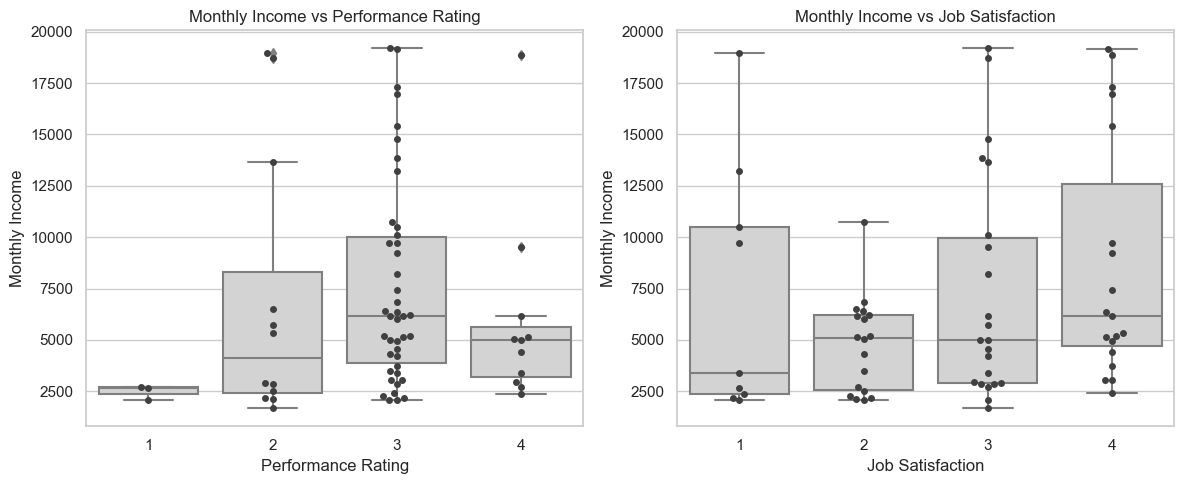

In [12]:
# ---------------------- Regression Model ----------------------
# This regression model identifies what factors influence monthly income (e.g. YearsAtCompany or PerformanceRating)
# It identifies which factors are meaningful, and which ones only add irrelevant noise
# It then compares the predictions between genders to see if there are any differences
# Lastly, it shows how income relates to performance and job satisfaction

# Data Loading with SQL JOIN using the new connection function
conn = get_sql_connection()
query = """
SELECT 
    e.EmployeeID,
    e.Age,
    e.Gender,
    e.JobLevel,
    c.MonthlyIncome,
    c.PercentSalaryHike,
    p.JobSatisfaction,
    p.PerformanceRating,
    p.TrainingTimesLastYear,
    p.YearsAtCompany
FROM Employee e
LEFT JOIN Compensation c ON e.EmployeeID = c.EmployeeID
LEFT JOIN Performance p ON e.EmployeeID = p.EmployeeID
"""
df = pd.read_sql(query, conn)
print("✅ Data Loaded. Shape:", df.shape)

# ---------------------- Feature Selection and Preprocessing ----------------------
# Define target and features.
target = 'MonthlyIncome'
features = ['Age', 'Gender', 'JobLevel', 'YearsAtCompany', 'PerformanceRating', 
            'JobSatisfaction', 'PercentSalaryHike', 'TrainingTimesLastYear']

# Create feature and target DataFrames
X = df[features]
y = df[target]

# Identify categorical features (here, only 'Gender' remains)
categorical_features = ['Gender']
numerical_features = [col for col in features if col not in categorical_features]

# Preprocessing pipeline: scale numeric data and one-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# ---------------------- Train/Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# ---------------------- Feature Selection using RFECV ----------------------
lr = LinearRegression()
rfecv = RFECV(estimator=lr, step=1, cv=5, scoring='r2')
rfecv.fit(X_train_transformed, y_train)
print("Optimal number of features selected by RFECV:", rfecv.n_features_)

X_train_selected = rfecv.transform(X_train_transformed)
X_test_selected = rfecv.transform(X_test_transformed)

# ---------------------- Fit Final Model on Selected Features ----------------------
final_model = LinearRegression()
final_model.fit(X_train_selected, y_train)
y_pred = final_model.predict(X_test_selected)

# ---------------------- Model Evaluation ----------------------
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = X_test_selected.shape[0]
k = X_test_selected.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

print("\nModel Evaluation with Feature Selection:")
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)
print("Adjusted R² Score:", adjusted_r2)

# ---------------------- Ranking Features by Importance ----------------------
# Get numerical feature names
num_feature_names = numerical_features

# Get categorical feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine the names: note that ColumnTransformer outputs numerical features first, then the categorical ones.
all_feature_names = num_feature_names + list(cat_feature_names)

# Create a DataFrame showing each feature's ranking from RFECV
ranking_df = pd.DataFrame({'Feature': all_feature_names, 'Ranking': rfecv.ranking_})
print(ranking_df)

# ---------------------- Fairness Analysis ----------------------
# Merge predictions with the original test set to analyze fairness by Gender.

results = X_test.copy()
results['ActualIncome'] = y_test
results['PredictedIncome'] = y_pred
results['Residual'] = results['ActualIncome'] - results['PredictedIncome']

fairness_summary = results.groupby('Gender')[['PredictedIncome', 'Residual']].mean()
print("\nFairness Analysis by Gender:")
print(fairness_summary)


# ---------------------- Responsiveness Analysis ----------------------

# Visualise relationships between MonthlyIncome and PerformanceRating / JobSatisfaction.
# Clean whitegrid style
sns.set(style="whitegrid")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define a uniform light grey color
box_color = "lightgrey"

# ---------------------- Plot 1: Monthly Income vs Performance Rating ----------------------
sns.boxplot(x='PerformanceRating', 
            y='MonthlyIncome', 
            data=df, 
            color=box_color,
            ax=axes[0])
sns.swarmplot(x='PerformanceRating', 
              y='MonthlyIncome', 
              data=df, 
              color=".25",
              ax=axes[0])
axes[0].set_title("Monthly Income vs Performance Rating")
axes[0].set_xlabel("Performance Rating")
axes[0].set_ylabel("Monthly Income")

# ---------------------- Plot 2: Monthly Income vs Job Satisfaction ----------------------
sns.boxplot(x='JobSatisfaction', 
            y='MonthlyIncome', 
            data=df, 
            color=box_color,
            ax=axes[1])
sns.swarmplot(x='JobSatisfaction', 
              y='MonthlyIncome', 
              data=df, 
              color=".25",  
              ax=axes[1])
axes[1].set_title("Monthly Income vs Job Satisfaction")
axes[1].set_xlabel("Job Satisfaction")
axes[1].set_ylabel("Monthly Income")

plt.tight_layout()
plt.show()
conn.close()

Enter database password: ········
✅ SQL Server connection established.
Total Budget Allocated: £600,000.00
Total Budget Used: £532,250.00
Amount in Reserve: £67,750.00
Percentage in Reserve: 11.29%
Percentage Used: 88.71%


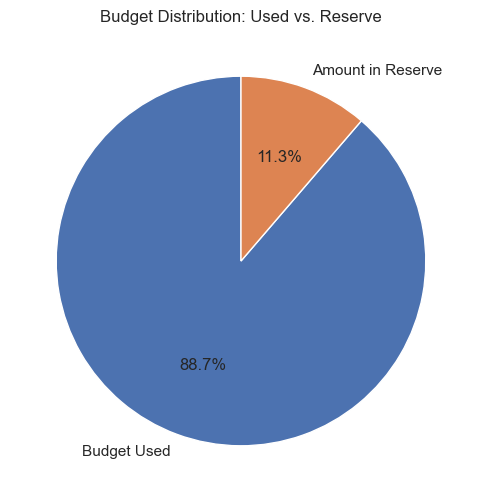

In [9]:
# ---------------------- Budget Analysis ----------------------
# Retrieves total department budget allocation and usage
# Calculates budget utilization and reserve percentages

# Connect to SQL database
conn = get_sql_connection()

# Query to calculate total budget allocated and used
query = """
SELECT 
    SUM(BudgetAllocated) AS TotalAllocated,
    SUM(BudgetUsed) AS TotalUsed
FROM Department
"""
df_totals = pd.read_sql(query, conn)
conn.close()

# Extract totals from the DataFrame
total_allocated = df_totals.iloc[0]['TotalAllocated']
total_used = df_totals.iloc[0]['TotalUsed']

# Calculate amount in reserve and percentages
amount_in_reserve = total_allocated - total_used
percentage_in_reserve = (amount_in_reserve / total_allocated) * 100
percentage_used = 100 - percentage_in_reserve

# Print the results
print("Total Budget Allocated: £{:,.2f}".format(total_allocated))
print("Total Budget Used: £{:,.2f}".format(total_used))
print("Amount in Reserve: £{:,.2f}".format(amount_in_reserve))
print("Percentage in Reserve: {:.2f}%".format(percentage_in_reserve))
print("Percentage Used: {:.2f}%".format(percentage_used))

# Data for visualisation
labels = ['Budget Used', 'Amount in Reserve']
values = [total_used, amount_in_reserve]

# ---- Pie Chart ----
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Budget Distribution: Used vs. Reserve')
plt.show()

**Regression Analysis**
=======
Key Predictor Selected:
- The feature selection method ended up choosing just one optimal factor (likely "JobLevel") as the strongest predictor of monthly income.

High Model Accuracy:
- The model explains roughly 93.5% of the variation in income, indicating a very good fit.

Important Influencing Factors:
- The ranking shows "JobLevel" is the top factor, followed by "PerformanceRating" and "PercentSalaryHike," suggesting these have the most influence on income predictions.

Gender Differences:
- The fairness check indicates that, on average, the model predicts significantly higher incomes for females compared to males, with different levels of prediction errors between the groups.

**Budget Analysis**
=======
Total Budget Allocated (£600,000):
- This is the overall amount made available for all departments combined.

Total Budget Used (£532,250):
- Indicates a high utilisation rate of the budget, showing active departmental spending.

Amount in Reserve (£67,750):
- A relatively small buffer remains, suggesting most of the budget has been consumed.

Percentage in Reserve (11.29%):
- Only a modest portion of the budget is left unused, which could indicate efficient planning—or a risk of overspending if unforeseen costs arise.

Percentage Used (88.71%): 
- High usage may reflect operational intensity, but also signals the need for close monitoring to avoid budget overruns.

In [ ]:
#  _   _      ____   ___  _          _                _                     
# | \ | | ___/ ___| / _ \| |        / \   _ __   __ _| |_   _ ___  ___  ___ 
# |  \| |/ _ \___ \| | | | |       / _ \ | '_ \ / _` | | | | / __|/ _ \/ __|
# | |\  | (_) |__) | |_| | |___   / ___ \| | | | (_| | | |_| \__ \  __/\__ \
# |_| \_|\___/____/ \__\_\_____| /_/   \_\_| |_|\__,_|_|\__, |___/\___||___/
#                                                       |___/               

In [5]:
# Find 3 manager feedback entries where performance rating is 1 or 2
results = manager_collection.find({"PerformanceRating": {"$in": [1, 2]}}).limit(3)

for doc in results:
    print(f"Employee ID: {doc['EmployeeID']}")
    print(f"PerformanceRating: {doc['PerformanceRating']}")
    print(f"ManagerFeedback: {doc['ManagerFeedback']}")
    print("-" * 50)

Employee ID: 100012877
PerformanceRating: 1
ManagerFeedback: Performance has been below acceptable standards and requires urgent attention.
--------------------------------------------------
Employee ID: 100013376
PerformanceRating: 2
ManagerFeedback: Performance is below expected level and needs improvement in key areas.
--------------------------------------------------
Employee ID: 100013536
PerformanceRating: 2
ManagerFeedback: Needs to focus more on accuracy and timely task completion.
--------------------------------------------------


In [6]:
# Find All Employees with Low Job Satisfaction (≤ 2)

low_satisfaction_employees = employee_collection.find({"JobSatisfaction": {"$lte": 2}})

# Limit to 5 results
for i, emp in enumerate(low_satisfaction_employees):
    if i == 5:
        print("...and more not shown.")
        break
    print(f"EmployeeID: {emp['EmployeeID']}")
    print(f"JobSatisfaction: {emp['JobSatisfaction']}")
    print(f"Feedback: {emp['EmployeeFeedback']}")
    print("-" * 50)

EmployeeID: 100012856
JobSatisfaction: 2
Feedback: The salary is okay but doesn’t quite match my expectations.
--------------------------------------------------
EmployeeID: 100012877
JobSatisfaction: 1
Feedback: The salary here is far below industry standards and demotivates me.
--------------------------------------------------
EmployeeID: 100013287
JobSatisfaction: 2
Feedback: There’s minimal growth in financial rewards.
--------------------------------------------------
EmployeeID: 100013328
JobSatisfaction: 2
Feedback: The job is fine but the pay could be more competitive.
--------------------------------------------------
EmployeeID: 100013376
JobSatisfaction: 2
Feedback: I feel I could be better compensated for my efforts.
--------------------------------------------------
...and more not shown.


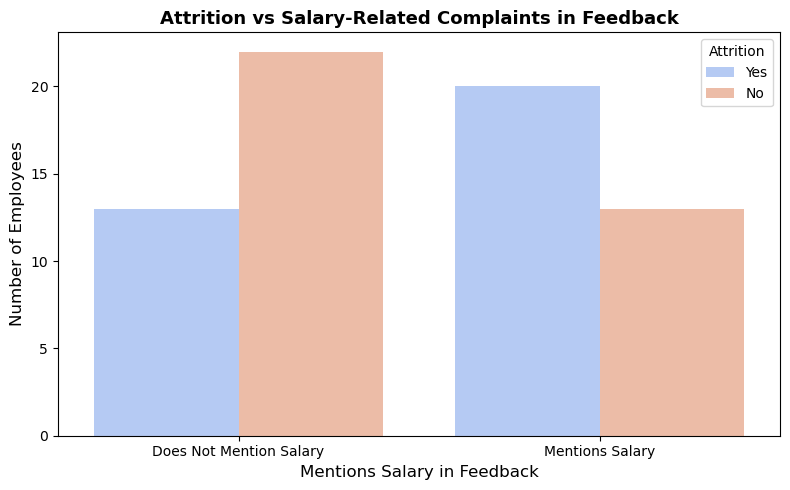

In [7]:
# Attrition vs Salary-Related Complaints in Feedback

# Retrieve the EmployeeFeedback collection
employee_collection = mongo_db["EmployeeFeedback"]

# Extract only the relevant fields from MongoDB: EmployeeFeedback and Attrition
# Excluding the _id field
employee_feedback_df = pd.DataFrame(list(
    employee_collection.find({}, {"EmployeeFeedback": 1, "Attrition": 1, "_id": 0})
))

# ---------------------- Step 1: Create function to detect salary mentions ----------------------
def mentions_salary(text):
    # If text is not a string, return False
    if not isinstance(text, str):
        return False
    keywords = ["salary", "pay", "compensation", "income", "wage", "bonus"]
    text = text.lower()
    return any(keyword in text for keyword in keywords)

# ---------------------- Step 2: Prepare DataFrame ----------------------
# Make a copy of the DataFrame to avoid SettingWithCopyWarning
employee_df_plot = employee_feedback_df.copy()

# Add a column for salary mentions
employee_df_plot["MentionsSalary"] = employee_df_plot["EmployeeFeedback"].apply(mentions_salary)

# ---------------------- Step 3: Plot grouped bar chart ----------------------
plt.figure(figsize=(8, 5))
sns.countplot(
    data=employee_df_plot,
    x="MentionsSalary",
    hue="Attrition",
    palette="coolwarm"
)

# Styling
plt.xticks([0, 1], ["Does Not Mention Salary", "Mentions Salary"])
plt.xlabel("Mentions Salary in Feedback", fontsize=12)
plt.ylabel("Number of Employees", fontsize=12)
plt.title("Attrition vs Salary-Related Complaints in Feedback", fontsize=13, fontweight="bold")
plt.legend(title="Attrition")
plt.tight_layout()
plt.show()


Extracted DataFrame head:
   EmployeeID Attrition  MonthlyIncome
0   100012856       Yes           5021
1   100012877       Yes           2073
2   100012882        No          18844
3   100012889        No          17328
4   100012911        No           2942


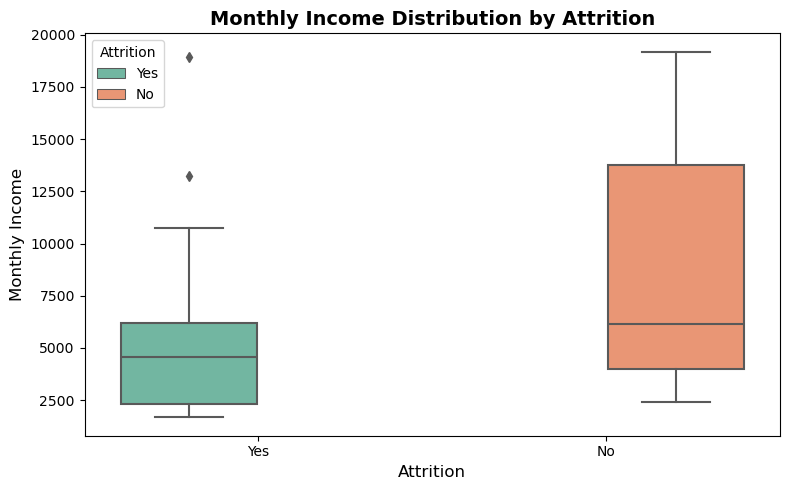

In [8]:
# Extract only the relevant fields into a DataFrame
cursor = employee_collection.find(
    {},
    {
        "EmployeeID": 1,
        "Attrition": 1,
        "MonthlyIncome": 1,
        "_id": 0
    }
)
employee_feedback_df = pd.DataFrame(list(cursor))
print("Extracted DataFrame head:")
print(employee_feedback_df.head())

# ---------------------- Plot: Monthly Income by Attrition ----------------------
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=employee_feedback_df,
    x="Attrition",
    y="MonthlyIncome",
    hue="Attrition",
    palette="Set2"
)

plt.title("Monthly Income Distribution by Attrition", fontsize=14, fontweight="bold")
plt.xlabel("Attrition", fontsize=12)
plt.ylabel("Monthly Income", fontsize=12)
plt.tight_layout()
plt.show()

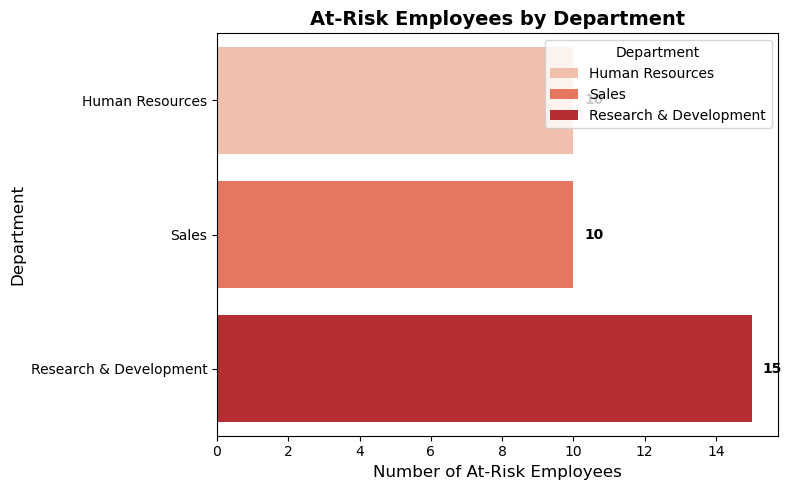

In [9]:
cursor = employee_collection.find(
    {},
    {
        "EmployeeID": 1,
        "Attrition": 1,
        "MonthlyIncome": 1,
        "Department": 1,
        "EmployeeFeedback": 1,
        "_id": 0
    }
)
employee_feedback_df = pd.DataFrame(list(cursor))

# Define the feedback DataFrame for clarity
df_feedback = employee_feedback_df.copy()

# Filter at-risk employees who stayed but might leave (Attrition == "No")
at_risk_employees = df_feedback[df_feedback["Attrition"] == "No"]

# Count of at-risk employees by department
dept_counts = at_risk_employees["Department"].value_counts().sort_values()

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=dept_counts.values,
    y=dept_counts.index,
    hue=dept_counts.index,  # assign hue based on department names
    palette="Reds",
    dodge=False
)
# Add count labels next to bars
for i, v in enumerate(dept_counts.values):
    ax.text(v + 0.3, i, str(v), color='black', va='center', fontweight='bold')

# Styling
plt.title("At-Risk Employees by Department", fontsize=14, fontweight="bold")
plt.xlabel("Number of At-Risk Employees", fontsize=12)
plt.ylabel("Department", fontsize=12)
plt.tight_layout()
plt.show()

**Attrition vs Salary-Related Complaints in Feedback** (Bar Chart)

- Attrition vs Salary-Related Complaints in Feedback (Bar Chart):
- Employees who mention salary in their feedback (with complaints) are more likely to leave the company.
- This highlights the potential link between salary dissatisfaction and higher attrition rates, indicating that salary-related issues should be addressed.

**Monthly Income Distribution by Attrition** (Box Plot)
- Employees who stay with the company have a more consistent monthly income distribution, while those who leave tend to have a higher range of income.
- This could suggest that higher earners are more likely to leave, possibly due to external offers or dissatisfaction with their pay.

**At-Risk Employees by Department** (Bar Chart)
- Research & Development has the highest number of at-risk employees, followed by Sales and Human Resources.
- This suggests that employee retention strategies may need to be focused more in the Research & Development department.
